## Task 6: Regression with External Data

**Description:**  
In this task, we aim to enhance our sales forecasting model by incorporating additional external datasets. By including factors such as weather conditions and economic indicators, we can improve the accuracy and robustness of our predictions.

**What we will be doing:**  
1. **Data Integration:**  
   - Merge the original sales dataset with external datasets, such as weather data (temperature, rainfall, humidity) and economic data (inflation, consumer index, etc.).
   - Ensure proper alignment of dates and store identifiers to maintain data consistency.

2. **Feature Engineering:**  
   - Create new features from the external datasets that may influence sales (e.g., rainy day flag, temperature ranges, economic trends).
   - Encode categorical variables where necessary.

3. **Model Training:**  
   - Train a regression model (Linear Regression, Ridge, or Lasso) using the combined dataset with new features.
   - Evaluate the model using metrics such as RMSE (Root Mean Squared Error) and MAE (Mean Absolute Error).

4. **Performance Measurement:**  
   - Compare the performance of the new model against the previous model without external data.
   - Analyze which external factors contribute most to improving forecast accuracy.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [10]:
train = pd.read_csv(r"C:\Users\Deepti\Downloads\train.csv", parse_dates=["date"])
stores = pd.read_csv(r"C:\Users\Deepti\Downloads\stores.csv")
transactions = pd.read_csv(r"C:\Users\Deepti\Downloads\transactions.csv", parse_dates=["date"])
oil = pd.read_csv(r"C:\Users\Deepti\Downloads\oil.csv", parse_dates=["date"])
holidays = pd.read_csv(r"C:\Users\Deepti\Downloads\holidays_events.csv", parse_dates=["date"])
weather = pd.read_csv(r"C:\Users\Deepti\Downloads\weather.csv", parse_dates=["date"])

print("Train:", train.shape)
print("Stores:", stores.shape)
print("Transactions:", transactions.shape)
print("Oil:", oil.shape)
print("Holidays:", holidays.shape)
print("Weather:", weather.shape)

Train: (3000888, 6)
Stores: (54, 5)
Transactions: (83488, 3)
Oil: (1218, 2)
Holidays: (350, 6)
Weather: (1461, 6)


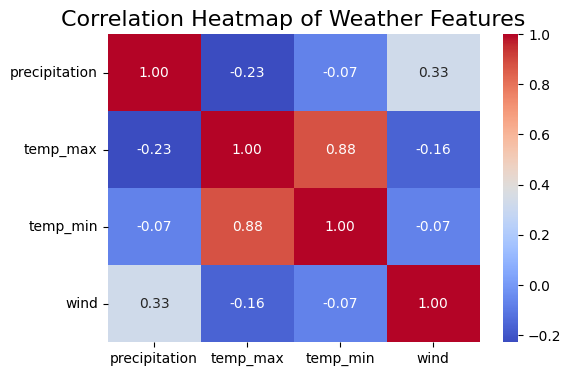

In [29]:
# Select only numeric columns from weather dataset
weather_numeric = weather.select_dtypes(include=np.number)

# Compute correlation matrix
weather_corr = weather_numeric.corr()

# Plot heatmap
plt.figure(figsize=(6,4))
sns.heatmap(weather_corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Weather Features", fontsize=16)
plt.show()

In [12]:
df = train.merge(stores, on="store_nbr", how="left")

df = df.merge(transactions, on=["date","store_nbr"], how="left")

df = df.merge(oil, on="date", how="left")

df = df.merge(holidays[["date","type"]], on="date", how="left")

print("Weather columns:", weather.columns)
print("Current df columns before weather merge:", df.columns)

if "city" in weather.columns:
    df = df.merge(weather, on=["date","city"], how="left")
else:
    df = df.merge(weather, on="date", how="left")

print("Final dataset shape:", df.shape)
df.head()

Weather columns: Index(['date', 'precipitation', 'temp_max', 'temp_min', 'wind', 'weather'], dtype='object')
Current df columns before weather merge: Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'type_x', 'cluster', 'transactions', 'dcoilwtico', 'type_y'],
      dtype='object')
Final dataset shape: (3054348, 18)


,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,transactions,dcoilwtico,type_y,precipitation,temp_max,temp_min,wind,weather
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday,0.0,5.0,-2.8,2.7,sun
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday,0.0,5.0,-2.8,2.7,sun
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday,0.0,5.0,-2.8,2.7,sun
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday,0.0,5.0,-2.8,2.7,sun
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday,0.0,5.0,-2.8,2.7,sun


In [15]:
import os
import warnings
warnings.filterwarnings("ignore")

if "family" in df.columns:
    df["family"] = df["family"].astype("category").cat.codes
if "city" in df.columns:
    df["city"] = df["city"].astype("category").cat.codes
if "state" in df.columns:
    df["state"] = df["state"].astype("category").cat.codes
if "type" in df.columns:   # holiday type column
    df["holiday_type"] = df["type"].astype("category").cat.codes
    df = df.drop(columns=["type"])   # drop original holiday text column

df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day
df["dayofweek"] = df["date"].dt.dayofweek

df = df.fillna(method="ffill")
df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,...,type_y,precipitation,temp_max,temp_min,wind,weather,year,month,day,dayofweek
0,0,2013-01-01,1,0,0.0,0,18,12,D,13,...,Holiday,0.0,5.0,-2.8,2.7,sun,2013,1,1,1
1,1,2013-01-01,1,1,0.0,0,18,12,D,13,...,Holiday,0.0,5.0,-2.8,2.7,sun,2013,1,1,1
2,2,2013-01-01,1,2,0.0,0,18,12,D,13,...,Holiday,0.0,5.0,-2.8,2.7,sun,2013,1,1,1
3,3,2013-01-01,1,3,0.0,0,18,12,D,13,...,Holiday,0.0,5.0,-2.8,2.7,sun,2013,1,1,1
4,4,2013-01-01,1,4,0.0,0,18,12,D,13,...,Holiday,0.0,5.0,-2.8,2.7,sun,2013,1,1,1


In [16]:
y = df["sales"]

X = df.drop(columns=["date","sales"])

print("Final Features shape:", X.shape)
X.head()

Final Features shape: (3054348, 20)


,id,store_nbr,family,onpromotion,city,state,type_x,cluster,transactions,dcoilwtico,type_y,precipitation,temp_max,temp_min,wind,weather,year,month,day,dayofweek
0,0,1,0,0,18,12,D,13,NaN,NaN,Holiday,0.0,5.0,-2.8,2.7,sun,2013,1,1,1
1,1,1,1,0,18,12,D,13,NaN,NaN,Holiday,0.0,5.0,-2.8,2.7,sun,2013,1,1,1
2,2,1,2,0,18,12,D,13,NaN,NaN,Holiday,0.0,5.0,-2.8,2.7,sun,2013,1,1,1
3,3,1,3,0,18,12,D,13,NaN,NaN,Holiday,0.0,5.0,-2.8,2.7,sun,2013,1,1,1
4,4,1,4,0,18,12,D,13,NaN,NaN,Holiday,0.0,5.0,-2.8,2.7,sun,2013,1,1,1


In [17]:
X_base = df[["store_nbr", "family", "onpromotion"]]
X_train, X_test, y_train, y_test = train_test_split(X_base, y, test_size=0.2, random_state=42)

lr_base = LinearRegression()
lr_base.fit(X_train, y_train)

y_pred_base = lr_base.predict(X_test)

mse_base = mean_squared_error(y_test, y_pred_base)
r2_base = r2_score(y_test, y_pred_base)

print("Baseline Model")
print("MSE:", mse_base)
print("R2 Score:", r2_base)

Baseline Model
MSE: 969752.8779776047
R2 Score: 0.1893602007713957


In [22]:
X = X.dropna()
y = y[X.index]  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr_full = LinearRegression()
lr_full.fit(X_train, y_train)

y_pred_full = lr_full.predict(X_test)

mse_full = mean_squared_error(y_test, y_pred_full)
r2_full = r2_score(y_test, y_pred_full)

print("Improved Model (with weather + economic + holidays + transactions)")
print("MSE:", mse_full)
print("R2 Score:", r2_full)

Improved Model (with weather + economic + holidays + transactions)
MSE: 921989.9084673856
R2 Score: 0.22928641794857252


In [23]:
print("Baseline Model -> MSE:", mse_base, ", R2:", r2_base)
print("Improved Model -> MSE:", mse_full, ", R2:", r2_full)

improvement = (r2_full - r2_base) * 100
print("Improvement in R²:", improvement, "%")


Baseline Model -> MSE: 969752.8779776047 , R2: 0.1893602007713957
Improved Model -> MSE: 921989.9084673856 , R2: 0.22928641794857252
Improvement in R²: 3.9926217177176815 %


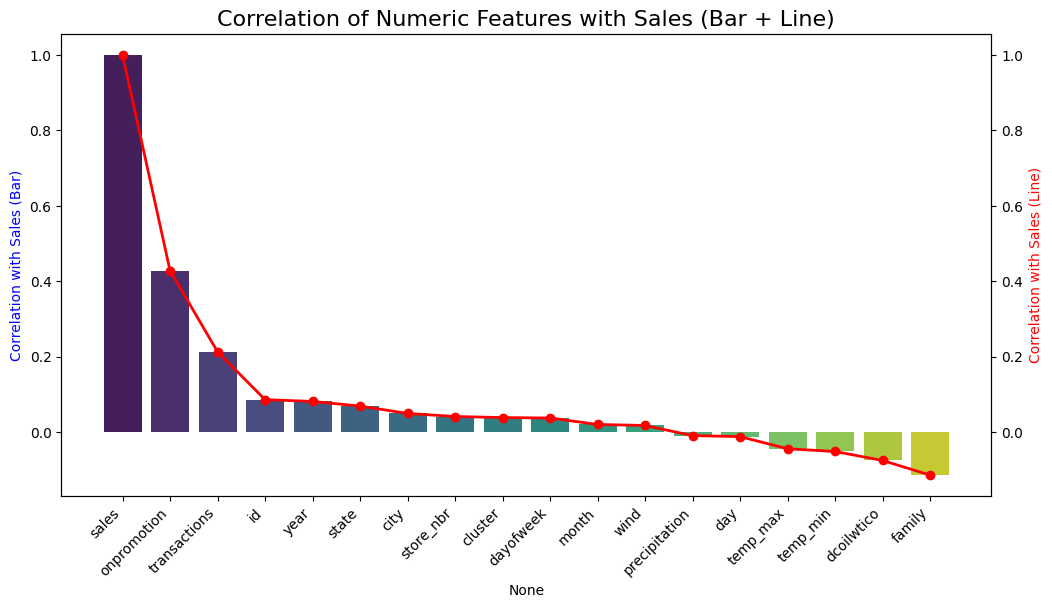

In [31]:
numeric_cols = df.select_dtypes(include=np.number)

sales_corr = numeric_cols.corr()["sales"].sort_values(ascending=False)

fig, ax1 = plt.subplots(figsize=(12,6))

sns.barplot(x=sales_corr.index, y=sales_corr.values, palette="viridis", ax=ax1)
ax1.set_ylabel("Correlation with Sales (Bar)", color="b")
ax1.set_xticklabels(sales_corr.index, rotation=45, ha="right")

ax2 = ax1.twinx()  
ax2.plot(sales_corr.index, sales_corr.values, color="red", marker="o", linewidth=2)
ax2.set_ylabel("Correlation with Sales (Line)", color="r")

plt.title("Correlation of Numeric Features with Sales (Bar + Line)", fontsize=16)
plt.show()

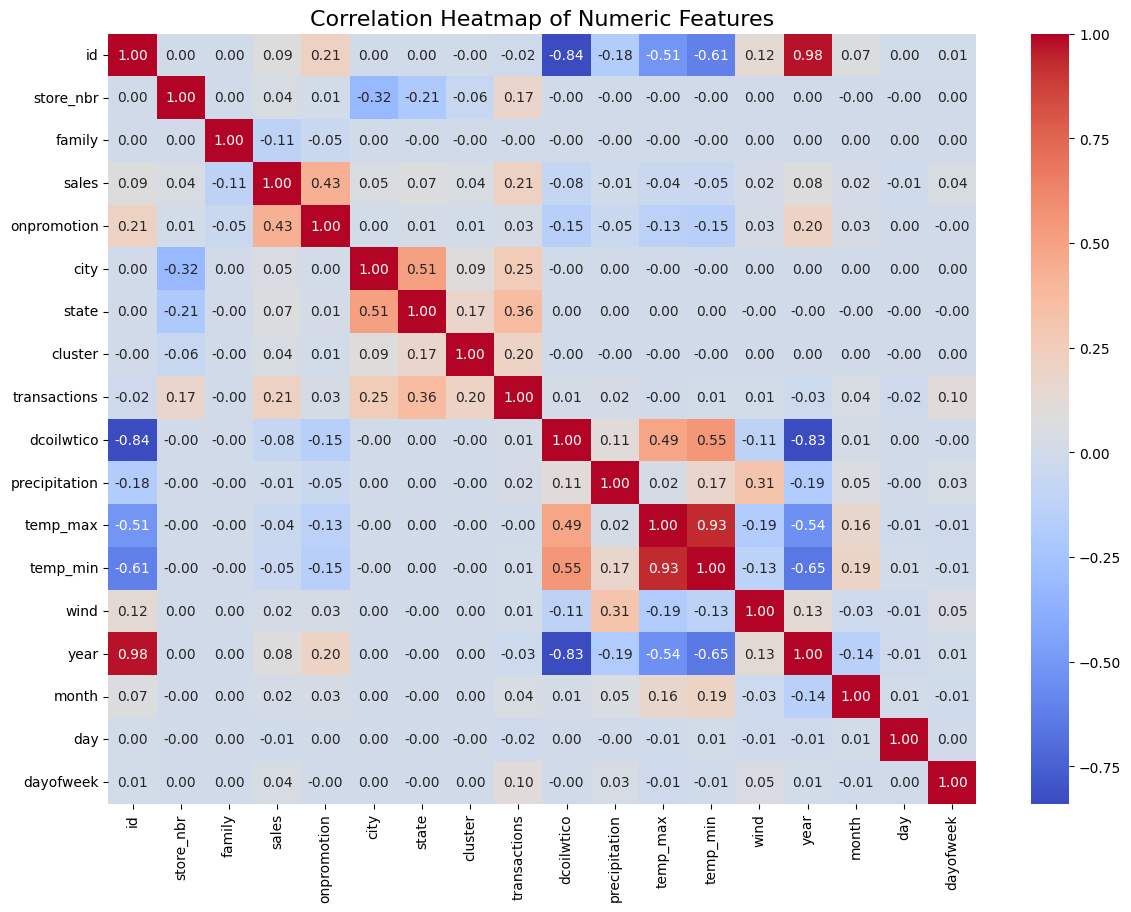

In [30]:
numeric_cols = df.select_dtypes(include=np.number)

corr_matrix = numeric_cols.corr()

plt.figure(figsize=(14,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Numeric Features", fontsize=16)
plt.show()